In [1]:
#Essential to have this equal to scaling during training.
RNN_INPUTS_SCALING_FACTOR = 1
SIGMA_TEMP = 0.01
PI_TEMP = 1.0
NUM_MIXTURES = 5
DREAM_WARM_STEPS = 0
#NB! important that this is the actual data the current RNN was trained
#on. Otherwise, the VAE may not have generated the same kinds of numbers.
RNN_TRAINING_DATA_FILE = "../dec6_models/rnn_training_data.npz"
LOADING_MODEL_PATH = "../dec14_bigbatch_1000epochs/trained_sequential_rnn_5mixtures_run1/rnn_trained_model.h5"


In [2]:
import keras
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

#Importing the VAE and RNN.
import os
import sys
#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Using TensorFlow backend.


/home/kaiolae/code/word_models_keras_test/WorldModels


In [3]:
#To access gym
import sys
sys.path.append('/home/kaiolae/.virtualenvs/worldmodels/lib/python3.5/site-packages')
import os

In [4]:

import analyze_rnn_predictions
%load_ext autoreload
%autoreload 2 #If we want to automatically load external modules as they are updated.

/home/kaiolae/code/word_models_keras_test/WorldModels


In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 2.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    #fig = plt.figure(figsize=(1,1), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [6]:
#loading_model_path = "../test_huge_data_2000/trained_sequential_rnn_5mixtures_run1/weights-improvement-173--69.81.hdf5"
rnn_analyzer = analyze_rnn_predictions.RNNAnalyzer(LOADING_MODEL_PATH, NUM_MIXTURES, PI_TEMP, io_scaling = RNN_INPUTS_SCALING_FACTOR)

VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   416         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_2[0][0]                   
_______________________

In [7]:
#Get a start video
#Getting data to feed into the VAE and RNN
import numpy as np
import os
import random
# load preprocessed data
training_data = np.load(RNN_TRAINING_DATA_FILE)
action_data = training_data['action']
observation_data = training_data['latent']

In [8]:
#Decode a sequence with the VAE and visualize it
def decode_and_visualize(latent_vector_sequence, rnn_analyzer):
    plot_movie_mp4(rnn_analyzer.decode_with_vae(latent_vector_sequence))

### Making a dream with the trained RNN

In [9]:
rnn_analyzer._reset()
WARM_STEPS = 100
latent_seq, action_seq = analyze_rnn_predictions.get_random_starting_sequence(observation_data,action_data,WARM_STEPS)
rnn_analyzer.warm_up_lstm_with_single_input(latent_seq[0], DREAM_WARM_STEPS)
#rnn_analyzer.warm_up_lstm(action_seq[:WARM_STEPS], latent_seq[:WARM_STEPS])
dreamed_latents = []
#TODO Rather than action 0, select random action.

num_timesteps=1000
for i in range(num_timesteps-1):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), sigma_temp=SIGMA_TEMP)
    dreamed_latents.append(dreamed_latent)
rnn_analyzer.decode_and_visualize(dreamed_latents)

<Figure size 64x64 with 0 Axes>

## Committing to one mixture during dreaming: 0,1,2,3

In [10]:
import count_monsters_and_balls
FIREBALL_THRESHOLD = 0.5
WALL_THRESHOLD = 0.39
def count_events_in_dream(dreamed_latent_sequence, rnn_analyzer, mixture_num):
    decoded_images = rnn_analyzer.decode_with_vae(dreamed_latent_sequence)
    num_explosions = 0
    num_fireballs = 0
    num_left_walls = 0
    num_right_walls = 0
    num_monster_appear = 0
    num_monster_disappear = 0
    num_fireballs_appear = 0
    
    prev_num_monsters = 0
    prev_num_fireballs = 0
    for img_counter in range(len(decoded_images)):
        img = decoded_images[img_counter]
        num_fireballs_in_current_frame, _ = count_monsters_and_balls.count_fireballs(img)
        num_monsters_in_current_frame, _ = count_monsters_and_balls.count_monsters(img)
        
        is_exploding = count_monsters_and_balls.is_there_a_big_explosion(img)
        is_fireball, _ = count_monsters_and_balls.count_fireballs(img)
        is_left_wall = count_monsters_and_balls.is_there_a_lefthand_wall(img, WALL_THRESHOLD)
        is_right_wall = count_monsters_and_balls.is_there_a_righthand_wall(img, WALL_THRESHOLD)

        if img_counter != 0 and not is_exploding:
            #Can't measure events in very first image, since events entail some change.
            # Also, during explosions, we cannot properly see events, so we don't count them.
            if num_monsters_in_current_frame > prev_num_monsters:
                #Monster appeared.
                num_monster_appear += 1
            if num_monsters_in_current_frame < prev_num_monsters:
                num_monster_disappear += 1
            if num_fireballs_in_current_frame > prev_num_fireballs:
                num_fireballs_appear +=1
                
        if not is_exploding: #During explosions, we do not count objects, since they are hidden.
            prev_num_fireballs = num_fireballs_in_current_frame
            prev_num_monsters = num_monsters_in_current_frame
                
                
        if is_exploding:
            num_explosions+=1
        elif is_fireball:
            num_fireballs+=1
        elif is_left_wall:
            num_left_walls+=1
        elif is_right_wall:
            num_right_walls+=1
            
    events_data = [{"type":"explosion", "count":num_explosions, "mixture_num":mixture_num},
                  {"type":"fireball", "count":num_fireballs, "mixture_num":mixture_num},
                  {"type":"left_wall", "count":num_left_walls, "mixture_num":mixture_num},
                  {"type":"right_wall", "count":num_right_walls, "mixture_num":mixture_num},
                  {"type":"monster_appear", "count":num_monster_appear, "mixture_num":mixture_num},
                  {"type":"monster_disappear", "count":num_monster_disappear, "mixture_num":mixture_num},
                  {"type":"fireball_appear", "count":num_fireballs_appear, "mixture_num":mixture_num}]
    

    return events_data

/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from

In [11]:
num_independent_tests = 10
warm_up_length = 150
num_dream_timesteps=1000
events_dicts=[]
for j in range(num_independent_tests):
    print("Step ", j)
    #Getting a random conditioning sequence to start the RNN.
    
    latent_sequence, action_sequence = analyze_rnn_predictions.get_random_starting_sequence(observation_data, action_data,warm_up_length)
    
    for i in range(NUM_MIXTURES):
        print(i, " mixtures")
        rnn_analyzer._reset()
        rnn_analyzer.warm_up_lstm_with_single_input(latent_sequence[0], DREAM_WARM_STEPS)
        #rnn_analyzer.warm_up_lstm(action_sequence[:warm_up_length], latent_sequence[:warm_up_length])
        dreamed_latents = []
        dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), previous_z=latent_sequence[warm_up_length], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = i)
        dreamed_latents.append(dreamed_latent)
        for dream_step in range(num_dream_timesteps-1):
            dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = i)
            dreamed_latents.append(dreamed_latent)
        events_dict = count_events_in_dream(dreamed_latents,rnn_analyzer,i)
        events_dicts.extend(events_dict)


Step  0
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  1
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  2
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  3
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  4
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  5
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  6
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  7
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  8
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  9
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures


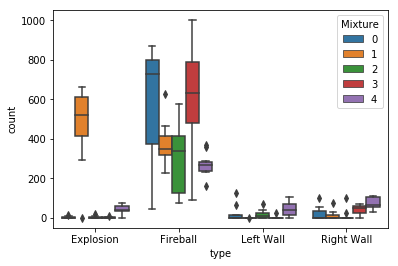

In [24]:
import pandas as pd
import seaborn as sns
#print(events_dicts)
#Plotting observed "worlds" when committing to one mixture.
events_frame_worlds= pd.DataFrame(events_dicts)
events_frame_worlds = events_frame_worlds[events_frame_worlds.type != "fireball_appear"]
events_frame_worlds = events_frame_worlds[events_frame_worlds.type != "fireball_disappear"]
events_frame_worlds = events_frame_worlds[events_frame_worlds.type != "monster_appear"]
events_frame_worlds = events_frame_worlds[events_frame_worlds.type != "monster_disappear"]
#events_frame = events_frame[events_frame.type != "left_wall"]
#events_frame = events_frame[events_frame.type != "right_wall"]

#Changing event names for better appearance.
events_frame_worlds['type'] = events_frame_worlds['type'].map({'explosion':'Explosion',
                                                                   'left_wall': 'Left Wall',
                                                                   'right_wall': 'Right Wall',
                                                                   'fireball': 'Fireball'
})
events_frame_worlds=events_frame_worlds.rename(columns={"mixture_num":"Mixture"})

sns.boxplot(x="type", y="count", hue="Mixture", data=events_frame_worlds)



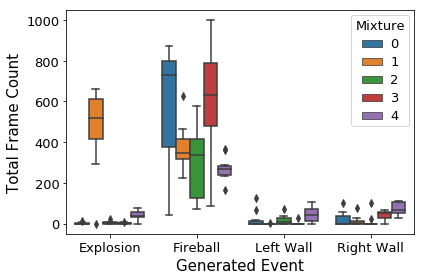

In [35]:
#Improving plot appearance.
#Annotating the plot with significance bars according to the results above.
# statistical annotation
FONT_SIZE = 15
FONT_SIZE_TICKS = 13
ax = sns.boxplot(x="type", y="count", hue="Mixture", data=events_frame_worlds)
#Changing axis labels
ax.set_xlabel('Generated Event', fontsize=FONT_SIZE)
ax.set_ylabel('Total Frame Count', fontsize=FONT_SIZE)
#Changing legend (I keep the original plot above to ensure I label things correctly).
plt.setp(ax.get_legend().get_texts(), fontsize=FONT_SIZE_TICKS) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=FONT_SIZE_TICKS) # for legend title
ax.tick_params(labelsize=FONT_SIZE_TICKS)
#ax.set_ylim(-0.1, 1.15) #To ensure both legend and markers fit in the plot

plt.tight_layout()
plt.savefig("committed_dreaming.pdf")
plt.show()

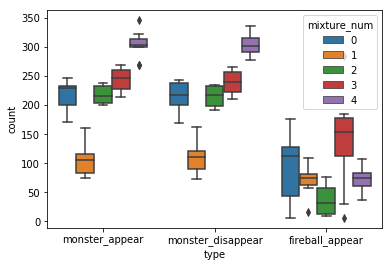

In [18]:
#Plotting stochastic events generated when committing to one mixture.
#print(events_dicts)
events_frame_events= pd.DataFrame(events_dicts)
events_frame_events = events_frame_events[events_frame_events.type != "fireball"]
events_frame_events = events_frame_events[events_frame_events.type != "explosion"]
events_frame_events = events_frame_events[events_frame_events.type != "left_wall"]
events_frame_events = events_frame_events[events_frame_events.type != "right_wall"]
sns.boxplot(x="type", y="count", hue="mixture_num", data=events_frame_events)



In [13]:
from scipy.stats import mannwhitneyu
explosion_rows = events_frame.loc[events_frame['type'] == "explosion"]
mixtures_to_explosion = {}
for mix_num in range(NUM_MIXTURES):
    mix_rows = explosion_rows.loc[explosion_rows['mixture_num'] == mix_num]['count'].tolist()
    mixtures_to_explosion[mix_num] = mix_rows
print(mixtures_to_explosion)
mannwhitneyu(mixtures_to_explosion[3], mixtures_to_explosion[4])

{0: [13, 0, 8, 0, 0, 0, 0, 0, 2, 4], 1: [0, 530, 637, 661, 446, 407, 528, 512, 292, 642], 2: [0, 6, 4, 22, 0, 10, 0, 0, 5, 0], 3: [0, 3, 1, 0, 1, 0, 8, 6, 2, 2], 4: [32, 23, 70, 0, 36, 37, 52, 39, 62, 77]}


/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/site-packages/scipy/stats/stats.py:4885: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


MannwhitneyuResult(statistic=8.5, pvalue=0.0009247701934301376)

In [68]:
def visualize_dream_images(z_sequence, rnn_analyzer,folder_name):
    columns = 4
    counter = 0
    skip_image = 5
    decoded_images = rnn_analyzer.decode_with_vae(z_sequence)
    plot_counter = 0
    
    rows = (len(decoded_images)/float(skip_image))/float(columns)
    f, axarr = plt.subplots(int(rows),int(columns), figsize=(50,50))
    f.subplots_adjust(hspace=0.25,wspace=-0.5)
    row = -1
    col = 0
    for d in decoded_images:
        if counter%skip_image == 0:
            if plot_counter%columns == 0:
                #print("Timestep: ", counter)
                row+=1
                col=0
                
            axarr[row,col].imshow(d) 
            plt.savefig(folder_name+"/"+str(counter)+".png")
            #axarr[row,col].set_title(str(counter), fontsize=20)
            axarr[row,col].axis('off')
            #plt.subplot((len(z_sequence)//skip_image)//columns + 1, columns, plot_counter+1)

            #plt.imshow(d)
            plot_counter+=1
            col+=1
        counter+=1
    #plt.tight_layout()

In [77]:
#Committed dreaming - Mixture 1
SAVEFOLDER = "mixture_1"
if not os.path.exists(SAVEFOLDER):
    os.mkdir(SAVEFOLDER)  
rnn_analyzer._reset()
latent_sequence, action_sequence = analyze_rnn_predictions.get_random_starting_sequence(observation_data, action_data,DREAM_WARM_STEPS)
rnn_analyzer.warm_up_lstm_with_single_input(latent_sequence[0],DREAM_WARM_STEPS)
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), previous_z=latent_sequence[1], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 1)
dreamed_latents.append(dreamed_latent)


for i in range(NUM_TIMESTEPS):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 1)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)
#visualize_dream_images(dreamed_latents, rnn_analyzer, SAVEFOLDER)

<Figure size 64x64 with 0 Axes>

In [45]:
#Committed dreaming - Mixture 2
rnn_analyzer._reset()
latent_sequence, action_sequence = analyze_rnn_predictions.get_random_starting_sequence(observation_data, action_data,DREAM_WARM_STEPS)
rnn_analyzer.warm_up_lstm_with_single_input(latent_sequence[0],DREAM_WARM_STEPS)
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), previous_z=latent_sequence[1], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 2)
dreamed_latents.append(dreamed_latent)


for i in range(NUM_TIMESTEPS):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 2)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

<Figure size 64x64 with 0 Axes>

In [76]:
#Committed dreaming - Mixture 3
SAVEFOLDER = "mixture_3"
if not os.path.exists(SAVEFOLDER):
    os.mkdir(SAVEFOLDER)   
rnn_analyzer._reset()
latent_sequence, action_sequence = analyze_rnn_predictions.get_random_starting_sequence(observation_data, action_data,DREAM_WARM_STEPS)
rnn_analyzer.warm_up_lstm_with_single_input(latent_sequence[0],DREAM_WARM_STEPS)
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), previous_z=latent_sequence[1], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 3)
dreamed_latents.append(dreamed_latent)


for i in range(NUM_TIMESTEPS):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 3)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)
#visualize_dream_images(dreamed_latents, rnn_analyzer, SAVEFOLDER)

<Figure size 64x64 with 0 Axes>

In [49]:
#Committed dreaming - Mixture 4
rnn_analyzer._reset()
latent_sequence, action_sequence = analyze_rnn_predictions.get_random_starting_sequence(observation_data, action_data,DREAM_WARM_STEPS)
rnn_analyzer.warm_up_lstm_with_single_input(latent_sequence[0],DREAM_WARM_STEPS)
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), previous_z=latent_sequence[1], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 4)
dreamed_latents.append(dreamed_latent)


for i in range(NUM_TIMESTEPS):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(rnn_analyzer.generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 4)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

<Figure size 64x64 with 0 Axes>